In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import seaborn
import networkx
from grave import grave
from SuchTree import SuchTree, SuchLinkedTrees
import pandas
import cartopy.crs
from cartopy.io.img_tiles import OSM
#from geopy.geocoders import Nominatim
#from geopy.distance import geodesic
from scipy.cluster import hierarchy
import screed
#import os
import pyprind

Populating the interactive namespace from numpy and matplotlib


In [3]:
metadata = pandas.read_csv( 'data/Table1_5_combined.txt', sep='\t', 
                      dtype={'Body_site':str, 'POGs_SUBFAMILY':str} )
metadata.head()

,UViG,TAXON_OID,Scaffold_ID,VIRAL_CLUSTERS,Ecosystem,Ecosystem_Category,Ecosystem_Type,Ecosystem_Subtype,Habitat,Body_site,...,Host,Host_detection,Host_domain,Estimated_completeness,Quality,POGs_ORDER,POGs_FAMILY,POGs_SUBFAMILY,POGs_GENUS,putative_retrovirus
0,2003000007_____2003296998,2003000007,2003296998,sg_24096,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
1,2003000007_____2003297061,2003000007,2003297061,sg_24097,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
2,2003000007_____2003297087,2003000007,2003297087,sg_24098,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
3,2003000007_____2003297164,2003000007,2003297164,sg_24099,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
4,2003000007_____2003297262,2003000007,2003297262,sg_24100,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,NaN,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN


In [4]:
lastal_cols = [ 'query_id', 'subject_id', 'identity', 'alignment_length',
                'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start',
                's_end', 'evalue', 'bitscore', 'query_length', 'subject_length',
                'raw_score' ]

df = pandas.read_csv( 'data/spacers_vs_all_viral_sequences_combined_v2_Filtered_1Snp_100AF.lout', 
                      sep='\t', names=lastal_cols, index_col=False )

# merge viral clusters
clusters = metadata[ ['UViG', 'VIRAL_CLUSTERS'] ]
clusters.columns = [ 'subject_id', 'vcluster' ]
df = df.merge( clusters, on='subject_id' )

# merge CRISPR array
df['CRISPR_array'] = [ ':'.join(name.split(':')[:2]) for name in df.query_id ]

print(df.shape)
df.head()

(90108, 17)


,query_id,subject_id,identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,query_length,subject_length,raw_score,vcluster,CRISPR_array
0,637000024:NC_003228:2:2998261,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34,sg_282454,637000024:NC_003228
1,637000024:NC_003228:2:2998455,7000000526_____SRS019397_WUGC_scaffold_4145,97.06,34,1,0,1,34,22655,22688,2.500000e-07,52.2,34,47940,32,sg_282454,637000024:NC_003228
2,647533110:NZ_GG705213:1:413342,7000000526_____SRS019397_WUGC_scaffold_4145,96.67,30,1,0,30,1,34447,34476,3.200000e-05,45.9,30,47940,28,sg_282454,647533110:NZ_GG705213
3,650377910:FQ312004:2:4712990,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,30,0,0,1,30,29564,29593,1.800000e-06,49.0,30,47940,30,sg_282454,650377910:FQ312004
4,2571042234:JGEV01000024:2:689262,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34,sg_282454,2571042234:JGEV01000024


In [10]:
v2h_taxonomy = pandas.read_csv( 'data/predicted_hosts.tsv', sep='\t' )

df['host_img_oid'] = [ int(i.split(':')[0]) for i in df['CRISPR_array'] ]

df = df.merge( v2h_taxonomy, left_on='host_img_oid', right_on='Host_Taxon_ID' )

In [11]:
G = networkx.convert_matrix.from_pandas_edgelist( df, 'CRISPR_array', 'vcluster', 'bitscore' )

networkx.set_node_attributes( G, { ':'.join(name.split(':')[:2]) : {'type':'CRISPR_array'} for name in df.query_id } )
networkx.set_node_attributes( G, { name : {'type':'vcluster'} for name in df.vcluster } )

# decompose graph into connected component subgraphs
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

In [12]:
bit_min = min( df['bitscore'] )
bit_max = max( df['bitscore'] )
bit_med = median( df['bitscore'] )

pandas.DataFrame.describe( df['bitscore'] )

count    1.053919e+07
mean     5.261946e+01
std      4.855740e+00
min      4.270000e+01
25%      4.900000e+01
50%      5.220000e+01
75%      5.690000e+01
max      1.550000e+02
Name: bitscore, dtype: float64

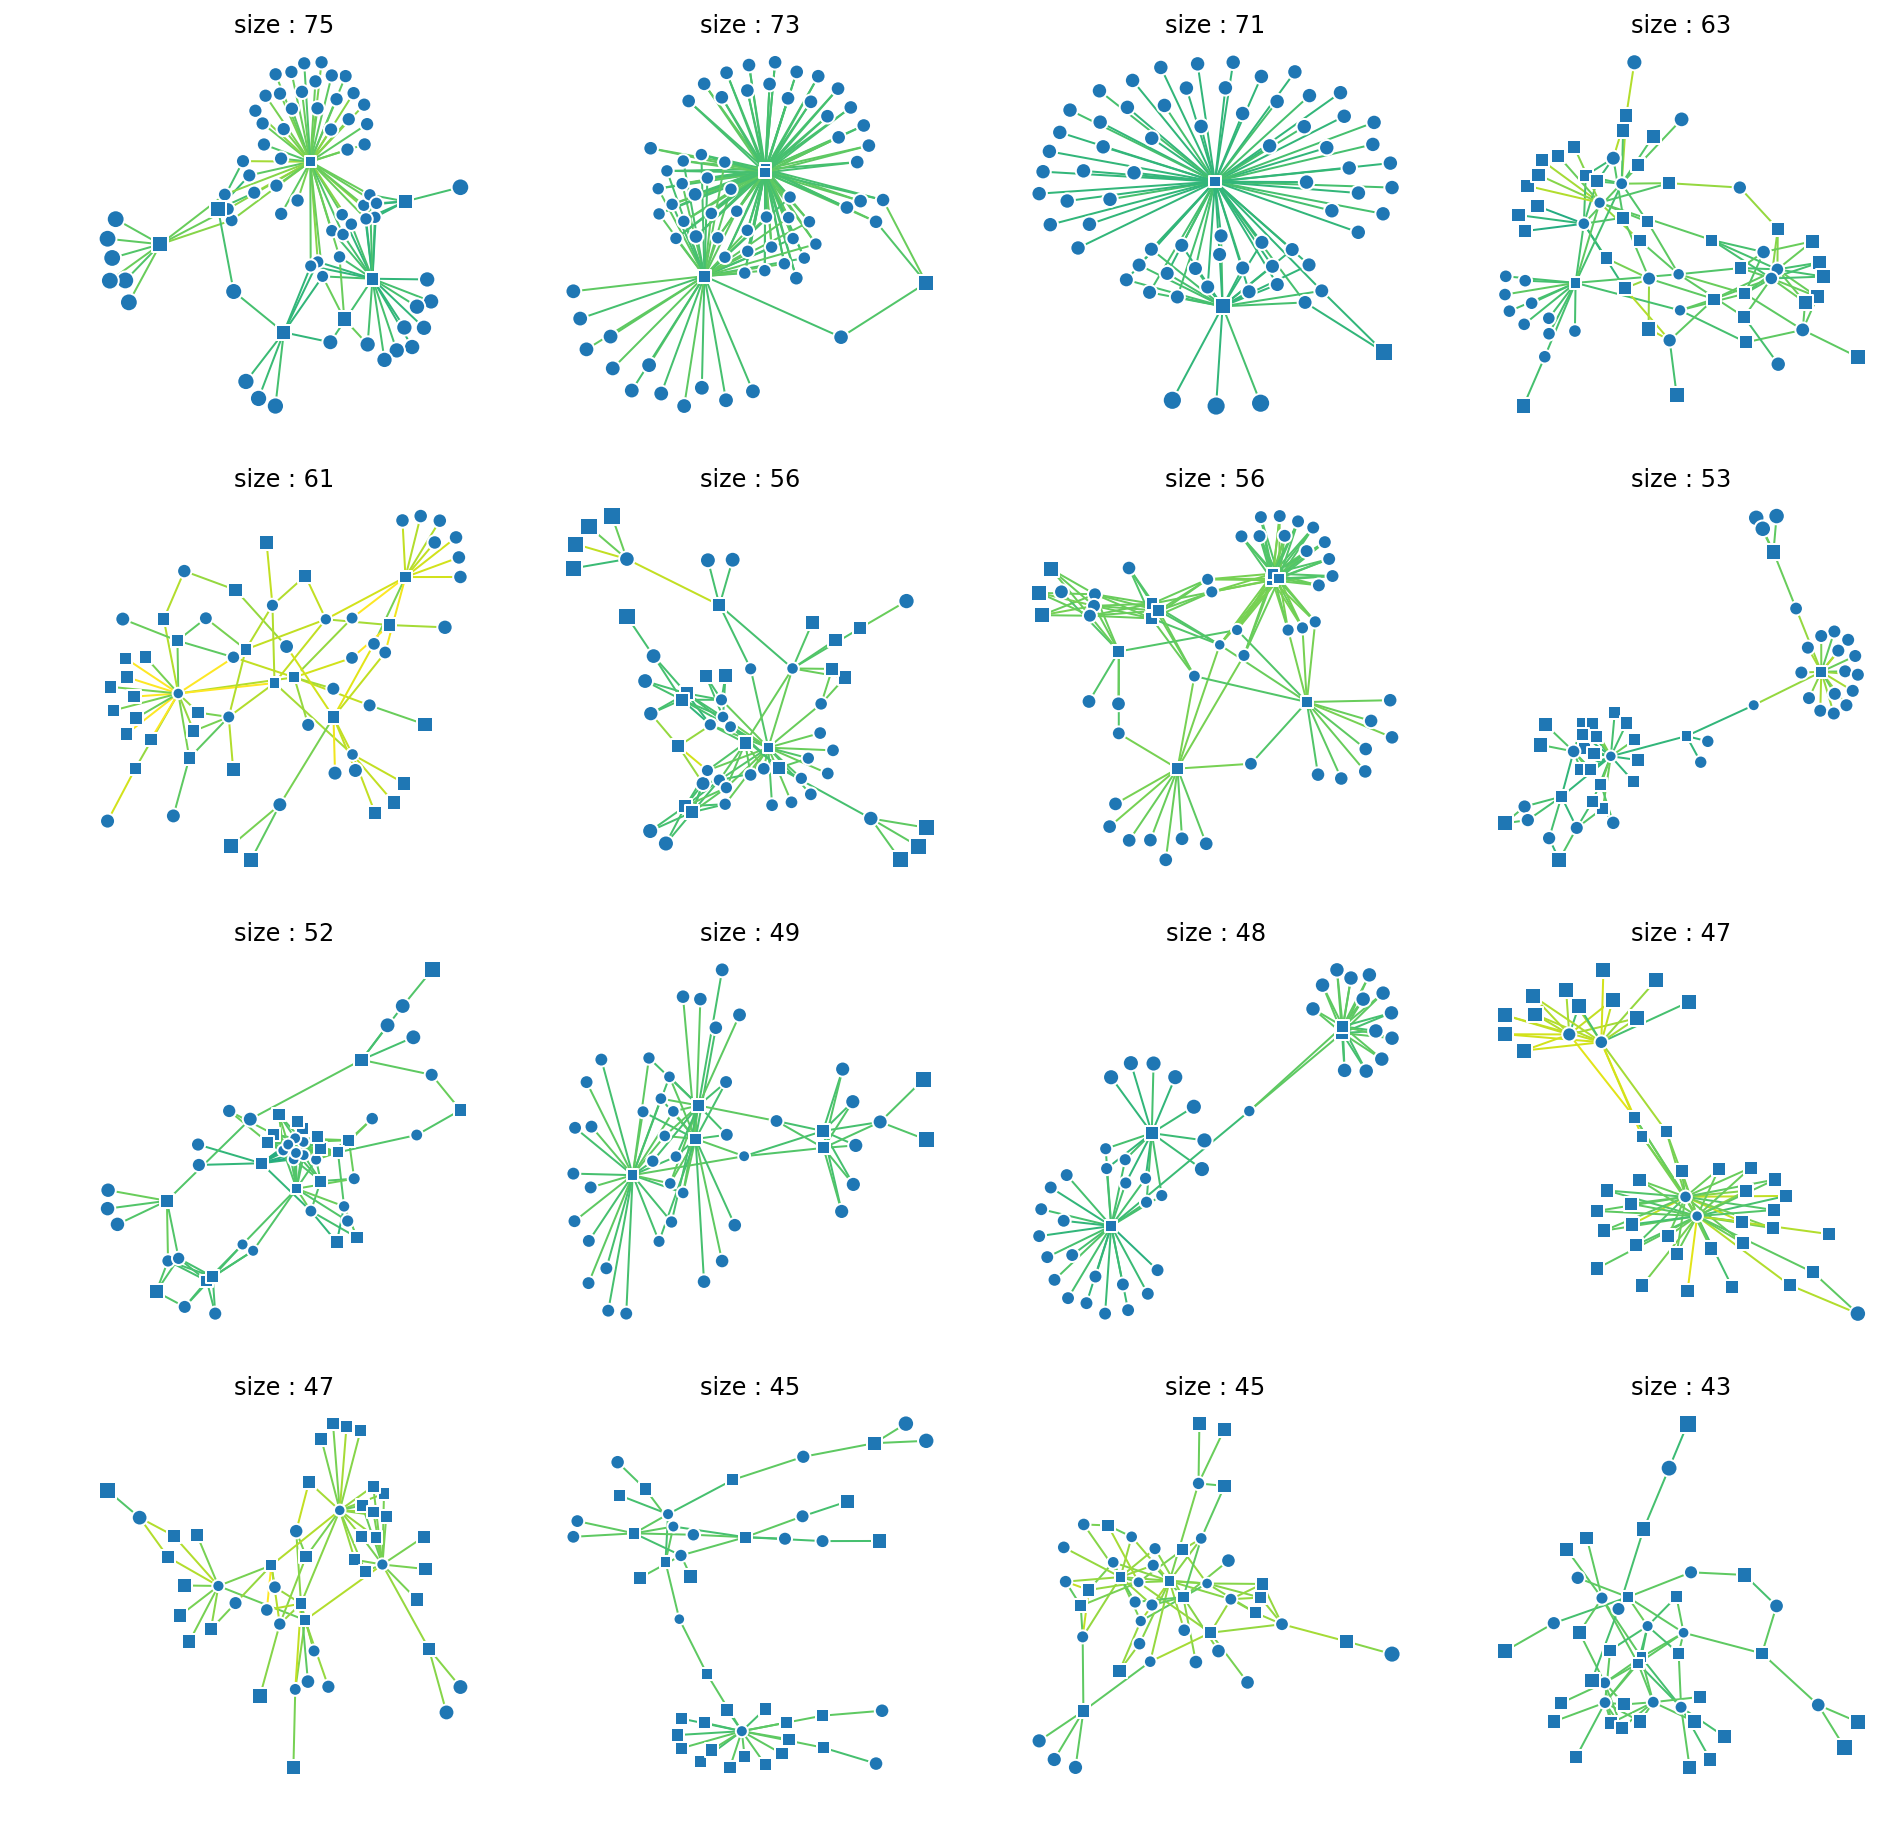

In [13]:
from grave import plot_network, use_attributes

figure( figsize = ( 16, 16 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

for n,g in enumerate(components[ 10:26 ]) :
    subplot( 4, 4, n+1 )
    title( ' : '.join( map( str, ('size', len(g) ) ) ) )
    
    centrality = networkx.closeness_centrality( g )
    max_centrality = max( centrality.values() )
    
    for node, node_attributes in g.nodes.data():
        node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
        if node_attributes['type'] == 'CRISPR_array' :
            node_attributes['shape'] = 's'
    
    for u, v, edge_attributes in g.edges.data():
        #c = (centrality[u] +
        #     centrality[v]) / 2
        #color_idx = (c / max_centrality)
        color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
        cmap = get_cmap()
        edge_attributes['color'] = cmap(color_idx)
        edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
    plot_network( g, layout='spring',
                  node_style=use_attributes(),
                  edge_style=use_attributes('color') )

In [135]:
CRISPR_taxon = df[ ['CRISPR_array', 'Host_Family' ] ].drop_duplicates()
CRISPR_taxon = { key : value for n,(key,value) in CRISPR_taxon.iterrows() }

progbar = pyprind.ProgBar( len(components), title='counting component taxa...' )
component_taxa = []
for n,g in enumerate( components ) :
    
    #centrality = networkx.closeness_centrality( g )
    #max_centrality = max( centrality.values() )
    
    taxa = {}
    for node, node_attributes in g.nodes.data() :
        if node_attributes['type'] == 'CRISPR_array' :
            taxa[node] = CRISPR_taxon[node]
    
    component_taxa.append( taxa )
    
    progbar.update()

counting component taxa...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


[]

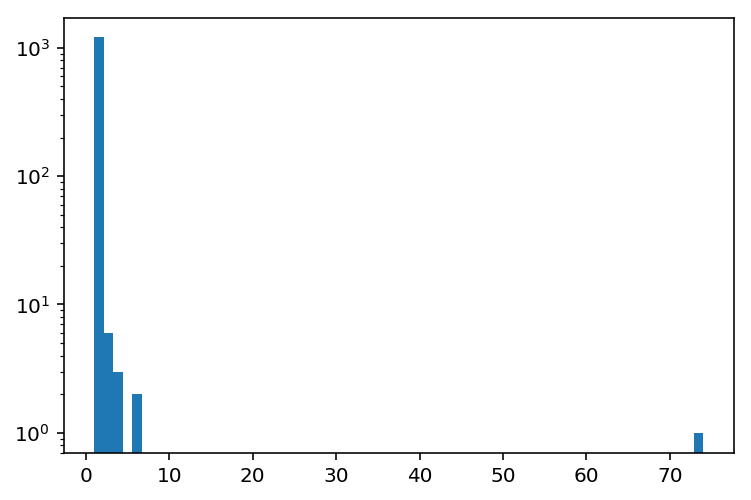

In [140]:
hist( [ len(set(taxa.values())) for taxa in component_taxa ], 64 )
semilogy()

No handles with labels found to put in legend.


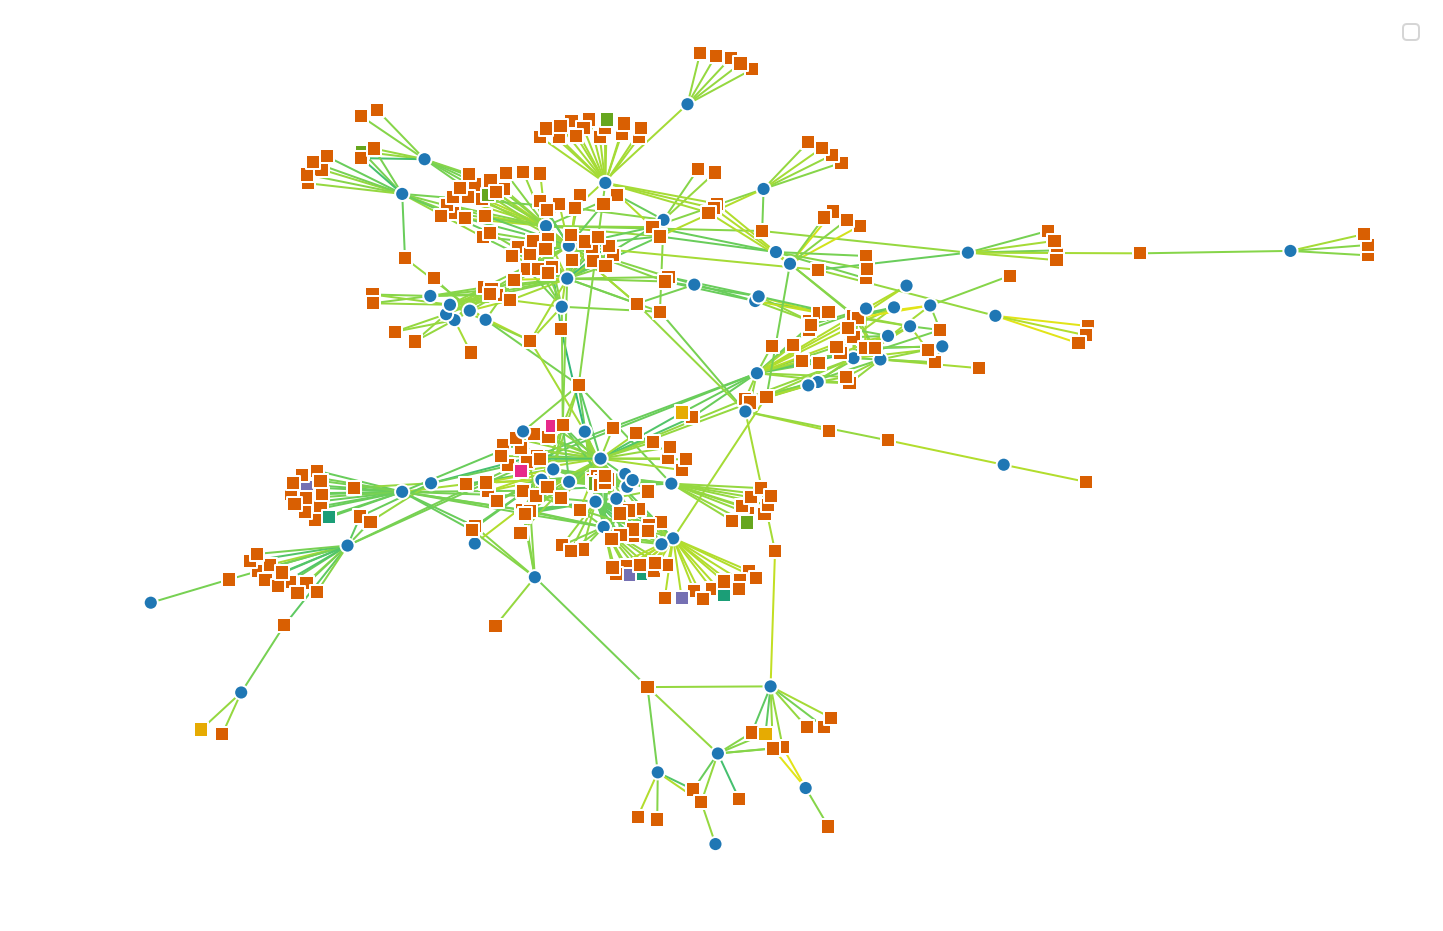

In [161]:
# Code cell for plotting an individual network

from grave import plot_network, use_attributes

colormap = matplotlib.cm.Dark2
n = 1

figure( figsize = ( 12, 8 ) )

#def edge_style(edge_attrs) :
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ) :
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

def node_style( node_attributes ) :
    return { 'label' : node_attributes.get( 'label' ) }

g = components[ n ]

centrality = networkx.closeness_centrality( g )
max_centrality = max( centrality.values() )

taxa = set( component_taxa[n].values() )
taxa_colors = { taxon : color for taxon, color in zip( taxa, colormap.colors[:len(taxa)] ) }

for node, node_attributes in g.nodes.data():
    node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
    if node_attributes['type'] == 'CRISPR_array' :
        node_attributes['shape'] = 's'
        node_attributes['color'] = taxa_colors[ component_taxa[n][node] ]
        node_attributes['label'] = component_taxa[n][node]

for u, v, edge_attributes in g.edges.data():
    color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
    cmap = get_cmap()
    edge_attributes['color'] = cmap(color_idx)
    edge_attributes['width'] = 2
    
plt = plot_network( g, layout='spring',
              node_style=use_attributes( [ 'label', 'color', 'shape' ] ),
              edge_style=use_attributes('color') )

legend()